# Automated Bug Priority Predictor

## Overview
This project aims to develop a machine learning model that predicts the **priority level of software bug reports** based on their text descriptions and metadata.
By automating the triage process, software teams can save time and focus on resolving critical issues faster.

**Datasets:** ISEC Data Challenge https://www.kaggle.com/competitions/isec-sdc-2025/overview

---

# 01 Exploration Data Analysis

## Objective
Explore and clean the data to prepare it for model training in the next phase.

## Notebook Goals
1. Load and inspect the dataset.
2. Understand column types and distribution.
3. Handle missing values and duplicates.
4. Clean and normalize text fields (tokenization, stopwords, lemmatization).
5. Prepare a clean dataset for feature extraction and modeling

## Imports and Setup

In [283]:
# Standard data libraries
import pandas as pd
import numpy as np

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Text processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.preprocessing import LabelEncoder

# Export precessed DataFrame
import joblib

# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rusty\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rusty\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [284]:
train_df = pd.read_csv("../../data/raw/train.csv")
test_df = pd.read_csv("../../data/raw/test.csv")

In [285]:
train_df

,Issue_id,Component,Title,Description,Status,Resolution,Priority
0,1700,Layout,font size 9px rounded down to 8px {font} {ll},There is a piece of code in the Windows GFX th...,VERIFIED,FIXED,0
1,7991,Plug-ins,Land OOP plugins in mozilla-central (preffed off),We need to land OOP plugins in mozilla-central...,RESOLVED,FIXED,0
2,1150,XPCOM,XP-COM Proxy code crashes when trying to AutoP...,(This bug imported from BugSplat; Netscapes in...,VERIFIED,FIXED,0
3,6143,XUL,crash setting display:none on grid rows [@ nsG...,User-Agent: Mozilla/5.0 (Windows; U; Win...,VERIFIED,FIXED,0
4,5952,Networking: Cache,limit the memory cache to a reasonable value,I have 1GB of RAM; so Im using 31MB of memory ...,VERIFIED,FIXED,0
...,...,...,...,...,...,...,...
52989,53192,Team,Replicate functionality (1GGP770),In regular use; it is often necessary to be ab...,RESOLVED,WONTFIX,4
52990,53717,CSS Parsing and Computation,[charset]Improve @charset parsing in CSSLoader...,Separated from bug 72658.; ; http://lxr.mozill...,RESOLVED,FIXED,4
52991,53242,Migration,iCab Profile Migrator,.,RESOLVED,WONTFIX,4
52992,53682,DOM: Core & HTML,The tableSectionElement.ch doesnt have a defau...,Overview Description: ; The tableSectionElemen...,VERIFIED,FIXED,4


In [286]:
train_df.shape

(52994, 7)

In [287]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52994 entries, 0 to 52993
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Issue_id     52994 non-null  int64 
 1   Component    52994 non-null  object
 2   Title        52994 non-null  object
 3   Description  52602 non-null  object
 4   Status       52994 non-null  object
 5   Resolution   52994 non-null  object
 6   Priority     52994 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.8+ MB


In [288]:
for col in ["Component", "Status", "Resolution"]:
  print("Column:", col)
  print("Unique values:", train_df[col].unique())
  print("Value count:", train_df[col].value_counts())

Column: Component
Unique values: ['Layout' 'Plug-ins' 'XPCOM' 'XUL' 'Networking: Cache' 'File Handling'
 'Untriaged' 'Security: UI' 'XPConnect' 'SocialAPI: Providers'
 'Layout: Form Controls' 'JavaScript Engine' 'Editor' 'DOM'
 'Event Handling' 'Embedding: APIs' 'Layout: Tables' 'Document Navigation'
 'Layout: Block and Inline' 'Geolocation' 'Graphics' 'DOM: Events'
 'General' 'Printing: Output' 'HTML: Parser' 'Tracking' 'Networking'
 'Installer: XPInstall Engine' 'Disability Access APIs' 'Profile: BackEnd'
 'HTML: Form Submission' 'Layout: Misc Code' 'Security: CAPS'
 'Build Config' 'Widget: Cocoa' 'WebRTC: Audio/Video' 'Spelling checker'
 'DOM: Apps' 'WebRTC: Networking' 'Selection' 'Security: PSM'
 'Developer Tools: Debugger' 'XML' 'DOM: Core & HTML' 'XBL'
 'Networking: HTTP' 'CSS Parsing and Computation' 'Layout: HTML Frames'
 'Print Preview' 'Developer Tools: Console' 'WebRTC' 'PDF Viewer'
 'Layout: R & A Pos' 'UI' 'WebRTC: Signaling' 'Layout: Floats' 'Security'
 'Networking: Cook

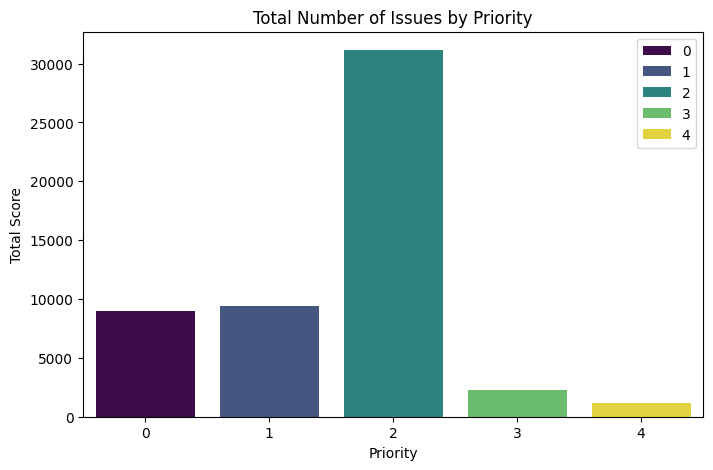

In [289]:
priority_dict = train_df["Priority"].value_counts().to_dict()
plt.figure(figsize=(8,5))
sns.barplot(
  x=list(priority_dict.keys()), 
  y=list(priority_dict.values()), 
  hue=list(priority_dict.keys()),
  palette="viridis"
)
plt.title("Total Number of Issues by Priority")
plt.xlabel("Priority")
plt.ylabel("Total Score")
plt.show()

In [290]:
pd.crosstab(train_df["Component"], train_df["Priority"])

Priority,0,1,2,3,4
Component,,,,,
Account Manager,14,5,6,1,1
Address Book,3,1,5,1,1
Bookmarks & History,9,219,169,122,36
Build Config,57,51,37,6,15
CSS Parsing and Computation,223,399,928,112,34
...,...,...,...,...,...
XUL,436,483,3024,166,67
jemalloc,3,0,0,0,0
js-ctypes,15,2,2,0,0


In [291]:
train_df["Priority"].value_counts()

Priority
2    31154
1     9412
0     8943
3     2287
4     1198
Name: count, dtype: int64

In [292]:
# List of descriptions per priority
train_df["Description"] = train_df["Description"].fillna("").astype(str)
grouped = train_df.groupby("Priority")["Description"].apply(lambda x: np.mean([len(t.split()) for t in x]))
grouped

Priority
0    116.869507
1    100.335104
2    103.180940
3     94.988631
4    142.715359
Name: Description, dtype: float64

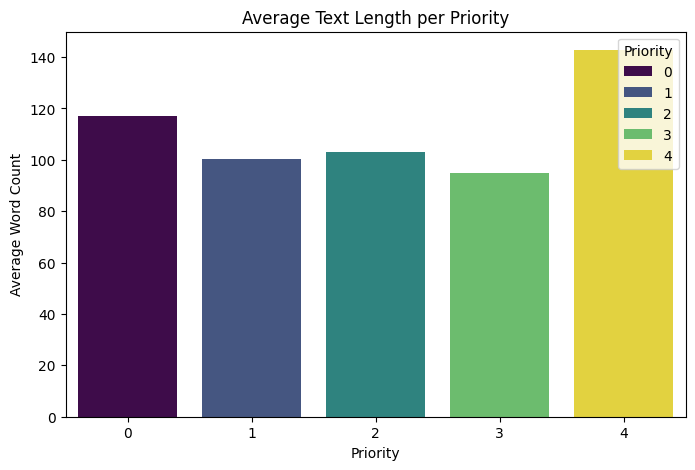

In [293]:
plt.figure(figsize=(8,5))
sns.barplot(
  x=grouped.index, 
  y=grouped.values,
  hue=grouped.index,
  palette="viridis"
)
plt.title("Average Text Length per Priority")
plt.xlabel("Priority")
plt.ylabel("Average Word Count")
plt.show()

In [294]:
# Create a DataFrame with number of words per title, description, and combined text
text_lengths_df = pd.DataFrame()
text_lengths_df["Title_Length"] = train_df["Title"].apply(lambda x: len(x.split()) if pd.notnull(x) else 0 )
text_lengths_df["Description_Length"] = train_df["Description"].apply(lambda x: len(x.split()) if pd.notnull(x) else 0 )

text_lengths_df.describe()

,Title_Length,Description_Length
count,52994.000000,52994.000000
mean,7.886855,105.525701
std,3.375861,154.644415
min,1.000000,0.000000
25%,6.000000,39.000000
50%,8.000000,70.000000
75%,10.000000,121.000000
max,46.000000,4122.000000


In [295]:
def plot_histogram(text_df, column_name):
  plt.figure(figsize=(8,5))
  plt.hist(text_df[column_name], bins=50, color='skyblue', edgecolor='black')
  plt.title(f"Distribution of {column_name}")
  plt.xlabel("Number of Words")
  plt.ylabel("Frequency")
  plt.show()

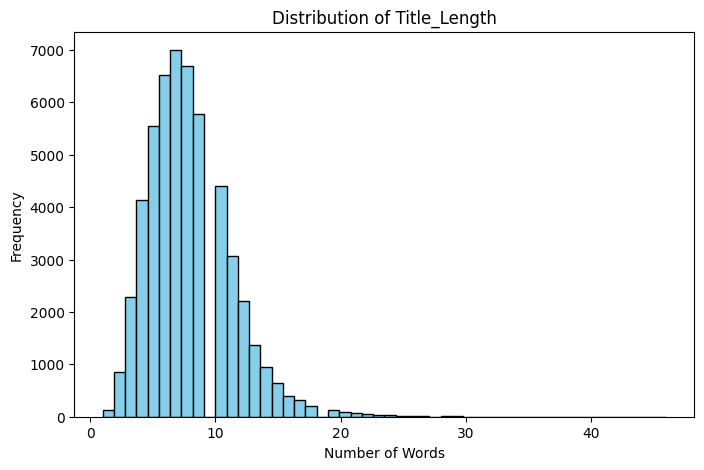

In [296]:
plot_histogram(text_lengths_df, "Title_Length")

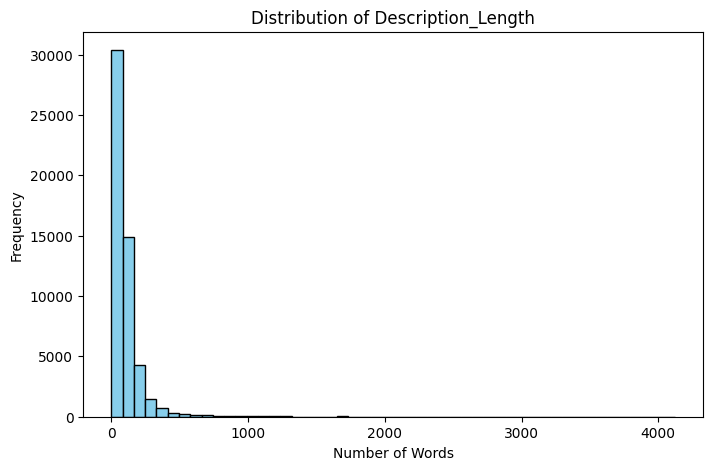

In [297]:
plot_histogram(text_lengths_df, "Description_Length")

In [298]:
text_lengths = text_lengths_df[["Description_Length", "Title_Length"]]
max_lengths = np.percentile(text_lengths, 95)
print("95th percentile of text length: ", max_lengths)

95th percentile of text length:  201.0


In [299]:
median_length = np.median(text_lengths)
max_length = np.max(text_lengths)
min_length = np.min(text_lengths)

print("Median length: ", median_length)
print("Max length: ", max_length)
print("Min length: ", min_length)

Median length:  14.0
Max length:  4122
Min length:  0


In [300]:
# Number of rows in text with less than equal to 296
num_text_to_target = sum(text_lengths_df["Description_Length"] <= 296)
percentage_of_target = (num_text_to_target / len(text_lengths_df)) * 100

print("Number of rows less than equal to target token limit: ", num_text_to_target)
print("Percentage of rows to the target token limit: ", percentage_of_target)

Number of rows less than equal to target token limit:  50507
Percentage of rows to the target token limit:  95.30701588859117


Set tokenizer max_length = 296, this will truncate outlier (4129)

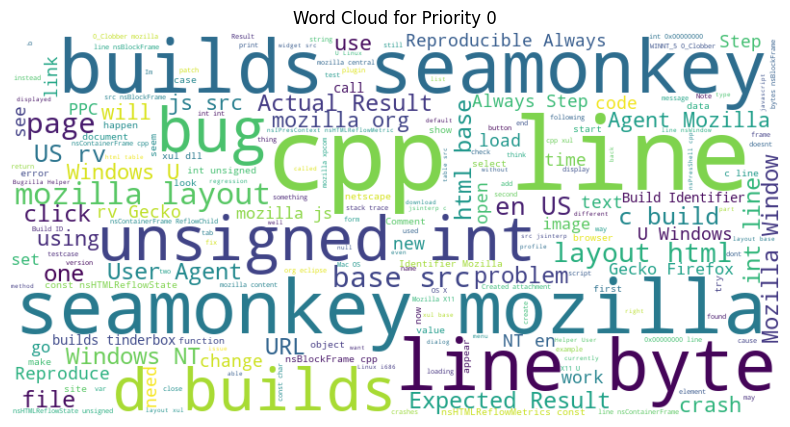

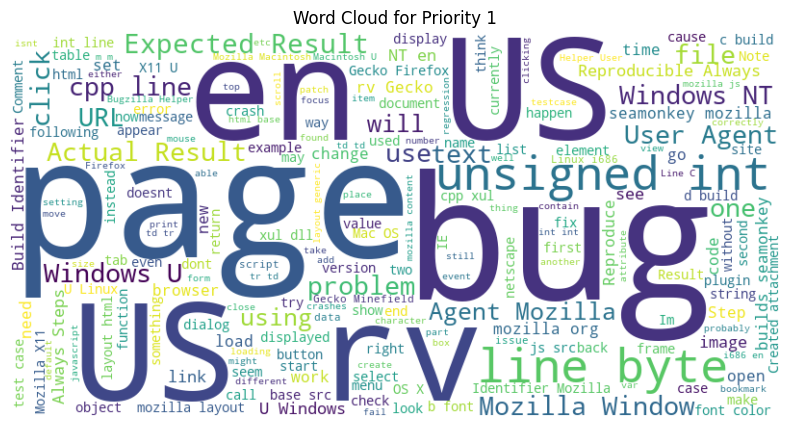

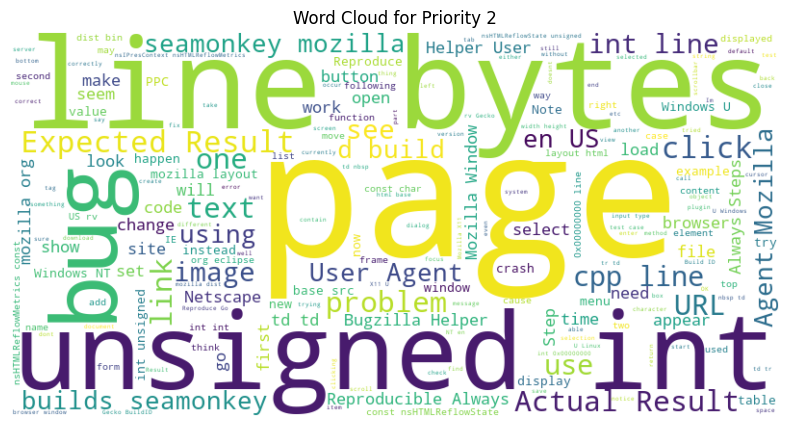

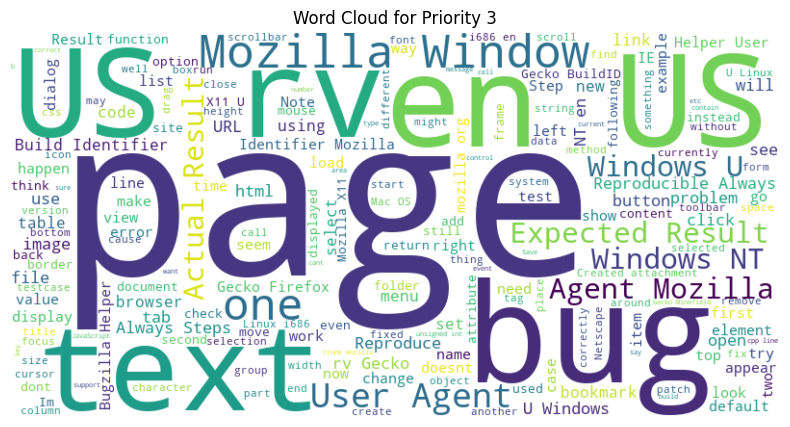

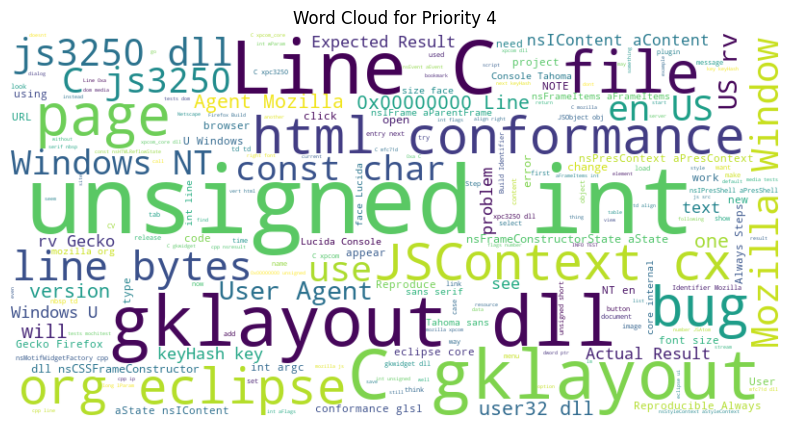

In [301]:
priority_list = train_df["Priority"].unique()

for priority_value in priority_list:
  subset = train_df[train_df["Priority"] == priority_value]
  text = " ".join(subset["Description"].astype(str))
  
  wc = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(text)

  plt.figure(figsize=(10,5))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis('off')
  plt.title(f"Word Cloud for Priority {priority_value}")
  plt.show()

In [302]:
num_unique_components = len(train_df["Component"].unique())
num_unique_components

183

In [303]:
component_counts = train_df["Component"].value_counts()
component_counts.head(20)

Component
Layout                         6129
XUL                            4176
Editor                         3043
JavaScript Engine              2513
Networking                     2417
Layout: Tables                 2027
Layout: Form Controls          1810
CSS Parsing and Computation    1696
HTML: Parser                   1656
Plug-ins                       1552
Security: UI                   1539
DOM: Core & HTML               1517
Internationalization           1447
XPCOM                          1347
Event Handling                 1044
DOM                            1000
ImageLib                        808
HTML: Form Submission           791
Tracking                        750
Installer: XPInstall Engine     714
Name: count, dtype: int64

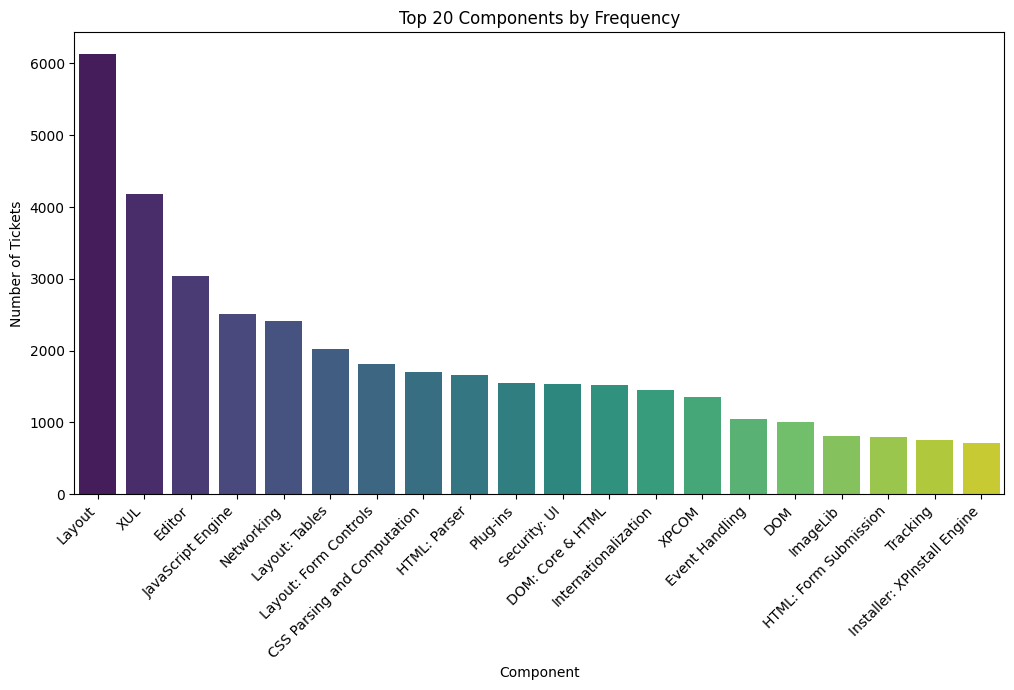

In [304]:
top_components = component_counts.head(20)
plt.figure(figsize=(12,6))
sns.barplot(
  x=top_components.index, 
  y=top_components.values,
  hue=top_components.index,
  palette="viridis",
  dodge=False
)
plt.title("Top 20 Components by Frequency")
plt.xlabel("Component")
plt.ylabel("Number of Tickets")
plt.xticks(rotation=45, ha="right")
plt.show()

In [305]:
component_ct = pd.crosstab(train_df["Component"], train_df["Priority"])
component_ct_percentage = component_ct.div(component_ct.sum(axis=1), axis=0) * 100
component_ct_percentage

Priority,0,1,2,3,4
Component,,,,,
Account Manager,51.851852,18.518519,22.222222,3.703704,3.703704
Address Book,27.272727,9.090909,45.454545,9.090909,9.090909
Bookmarks & History,1.621622,39.459459,30.450450,21.981982,6.486486
Build Config,34.337349,30.722892,22.289157,3.614458,9.036145
CSS Parsing and Computation,13.148585,23.525943,54.716981,6.603774,2.004717
...,...,...,...,...,...
XUL,10.440613,11.566092,72.413793,3.975096,1.604406
jemalloc,100.000000,0.000000,0.000000,0.000000,0.000000
js-ctypes,78.947368,10.526316,10.526316,0.000000,0.000000


<Figure size 1600x800 with 0 Axes>

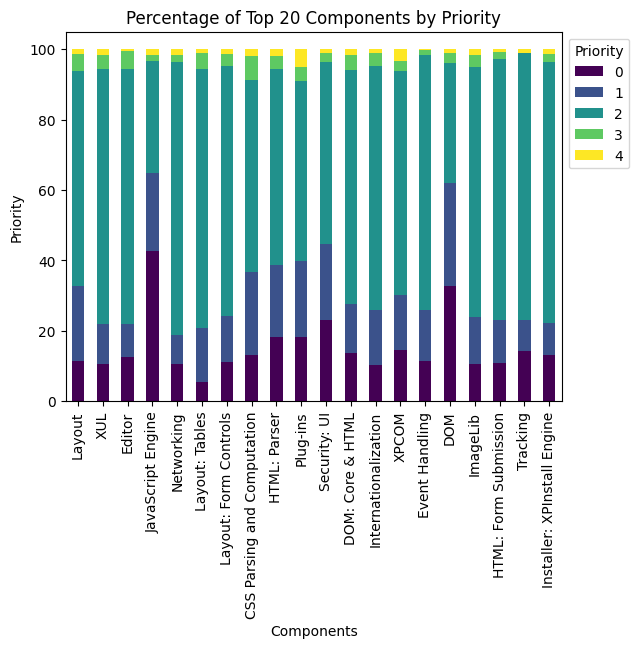

In [306]:
component_ct_top = component_ct_percentage.loc[top_components.index]

plt.figure(figsize=(16,8))
component_ct_top.plot(kind="bar", stacked=True, colormap="viridis")
plt.title("Percentage of Top 20 Components by Priority")
plt.ylabel("Priority")
plt.xlabel("Components")
plt.legend(title="Priority", bbox_to_anchor=(1,1), loc="upper left")
plt.show()

In [307]:
num_unique_status = len(train_df["Status"].unique())
num_unique_status

3

In [308]:
status_counts = train_df["Status"].value_counts()
status_counts

Status
VERIFIED    34258
RESOLVED    18396
CLOSED        340
Name: count, dtype: int64

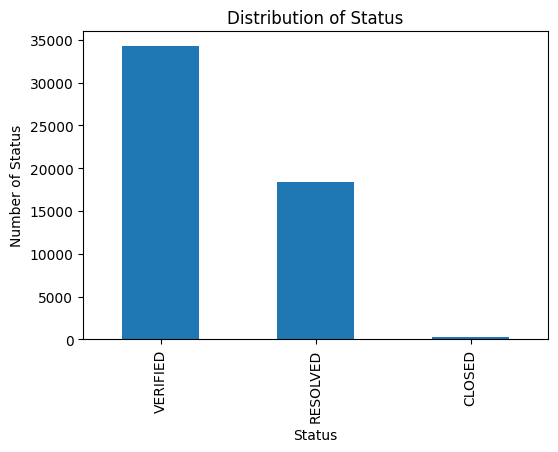

In [309]:
plt.figure(figsize=(6,4))
status_counts.plot(kind="bar")
plt.title("Distribution of Status")
plt.ylabel("Number of Status")
plt.xlabel("Status")
plt.show()

<Figure size 800x600 with 0 Axes>

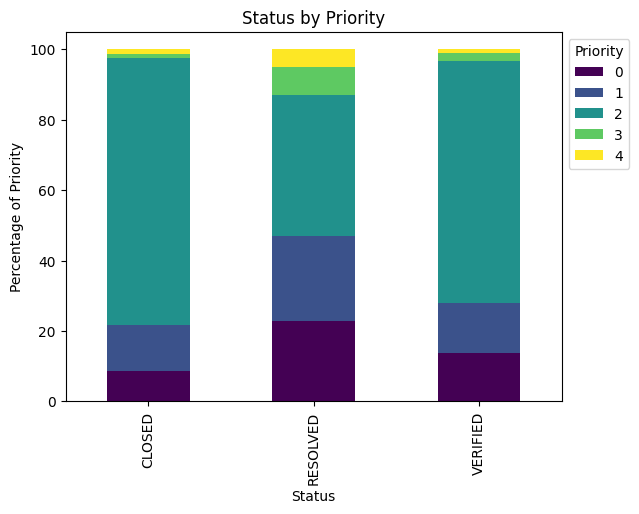

In [310]:
status_ct = pd.crosstab(train_df["Status"], train_df["Priority"])
status_ct_percentage = status_ct.div(status_ct.sum(axis=1), axis=0) * 100

plt.figure(figsize=(8,6))
status_ct_percentage.plot(kind="bar", stacked=True, colormap="viridis")
plt.title("Status by Priority")
plt.ylabel("Percentage of Priority")
plt.xlabel("Status")
plt.legend(title="Priority", bbox_to_anchor=(1,1), loc="upper left")
plt.show()

In [311]:
num_unique_resolution = len(train_df["Resolution"].unique())
num_unique_resolution

9

In [312]:
resolution_counts = train_df["Resolution"].value_counts()
resolution_counts

Resolution
FIXED         28647
DUPLICATE     10367
WORKSFORME     7742
INVALID        3687
WONTFIX        2208
INCOMPLETE      257
NDUPLICATE       73
EXPIRED           8
MOVED             5
Name: count, dtype: int64

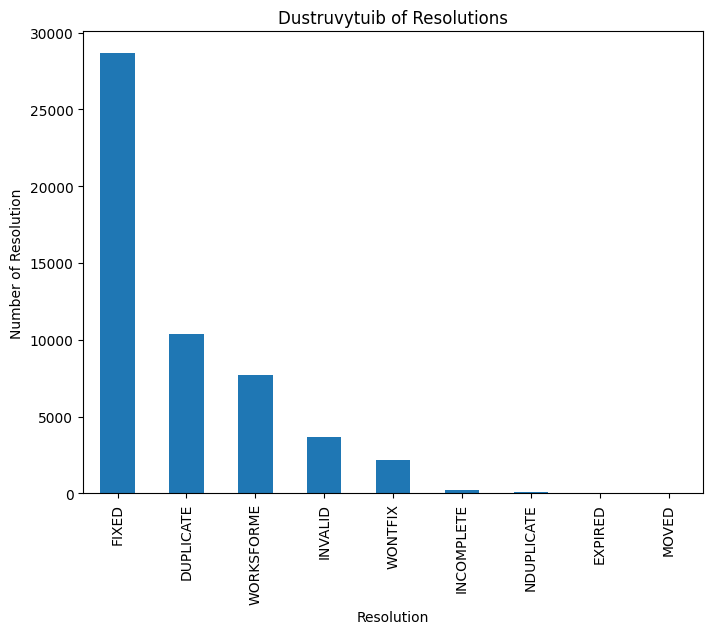

In [313]:
plt.figure(figsize=(8,6))
resolution_counts.plot(kind="bar")
plt.title("Dustruvytuib of Resolutions")
plt.ylabel("Number of Resolution")
plt.xlabel("Resolution")
plt.show()

<Figure size 800x600 with 0 Axes>

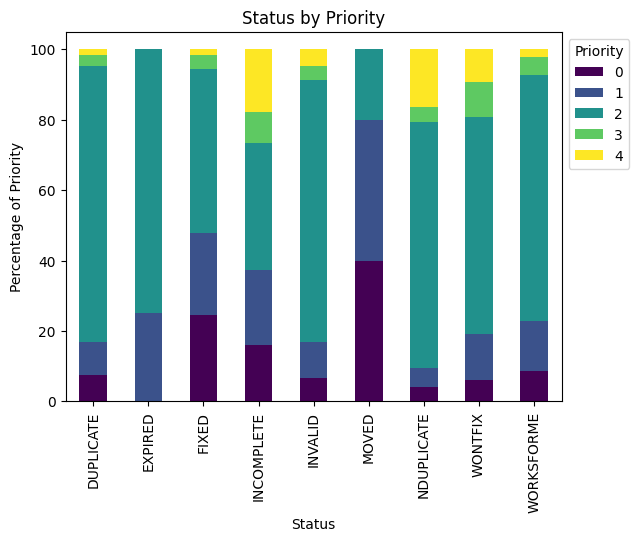

In [314]:
resolution_ct = pd.crosstab(train_df["Resolution"], train_df["Priority"])
resolution_ct_percentage = resolution_ct.div(resolution_ct.sum(axis=1), axis=0) * 100

plt.figure(figsize=(8,6))
resolution_ct_percentage.plot(kind="bar", stacked=True, colormap="viridis")
plt.title("Status by Priority")
plt.ylabel("Percentage of Priority")
plt.xlabel("Status")
plt.legend(title="Priority", bbox_to_anchor=(1,1), loc="upper left")
plt.show()

In [315]:
train_df.isnull().sum()

Issue_id       0
Component      0
Title          0
Description    0
Status         0
Resolution     0
Priority       0
dtype: int64

In [316]:
train_df[train_df["Description"].isnull()]

,Issue_id,Component,Title,Description,Status,Resolution,Priority


In [317]:
train_df["Title"].isnull().sum()


np.int64(0)

In [318]:
train_df["Description"] = train_df["Description"].fillna('')

In [319]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52994 entries, 0 to 52993
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Issue_id     52994 non-null  int64 
 1   Component    52994 non-null  object
 2   Title        52994 non-null  object
 3   Description  52994 non-null  object
 4   Status       52994 non-null  object
 5   Resolution   52994 non-null  object
 6   Priority     52994 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.8+ MB


In [320]:
train_df.isnull().sum()

Issue_id       0
Component      0
Title          0
Description    0
Status         0
Resolution     0
Priority       0
dtype: int64

In [321]:
duplicates = train_df[train_df.duplicated(subset=["Title", "Description"], keep=False)]
print("Number of duplicate rows: ", duplicates.shape[0])

Number of duplicate rows:  419


In [322]:
duplicates.head()

,Issue_id,Component,Title,Description,Status,Resolution,Priority
2138,2689,Layout: Form Controls,text entry into forms is CPU intensive.,From Bugzilla Helper:; User-Agent: Mozilla/5.0...,VERIFIED,DUPLICATE,0
2608,1490,Layout,[Dogfood] Delete is removing all my text from ...,Im assuming this is a HTML element or form con...,VERIFIED,DUPLICATE,0
3099,1264,DOM,[CRASH] A crash occurs with a A element that c...,Version: Apprunner; Build: 1999082412 (Aug 24 ...,VERIFIED,FIXED,0
4107,1315,Editor,Crash Clicking Cancel button in Link Propertie...,Build 1999090909; Steps to Reproduce:; 1) Laun...,VERIFIED,FIXED,0
4291,482,JavaScript Engine,Bogus property is not defined errors,The lookup code for the JavaScript property ca...,VERIFIED,INVALID,0


In [323]:
# Removing duplicate but keeping first occurrance
train_df = train_df.drop_duplicates(subset=["Title", "Description"], keep="first")
print("Dataset shape after removing duplicates: ", train_df.shape)

Dataset shape after removing duplicates:  (52767, 7)


In [324]:
stop_words = set(stopwords.words("english")).union({"issue", "ticket", "problem"})
lemmatizer = WordNetLemmatizer()

all_text = " ".join(
  train_df["Title"].fillna("").tolist() + 
  train_df["Description"].fillna("").tolist()
)

tokenized_text = [
  lemmatizer.lemmatize(word.lower())
  for word in re.findall(r"[a-z]+", all_text)
  if len(word) > 2
]

word_counts = Counter(tokenized_text)
rare_words = {word for word, count in word_counts.items() if count == 1}

def clean_text(text):
  text = re.sub(r"http\S+|www\S+", "", str(text).lower())
  text = re.sub(r"[^a-z\s]", " ", text)
  text = re.sub(r"\s+", " ", text).strip()
  return " ".join(
    lemmatizer.lemmatize(word) 
    for word in text.split() 
    if word not in stop_words and word not in rare_words and len(word) > 2
  )

In [325]:
train_df["Title"] = train_df["Title"].apply(clean_text)
train_df["Description"] = train_df["Description"].apply(clean_text)

C:\Users\rusty\AppData\Local\Temp\ipykernel_23860\3884501909.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["Title"] = train_df["Title"].apply(clean_text)
C:\Users\rusty\AppData\Local\Temp\ipykernel_23860\3884501909.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["Description"] = train_df["Description"].apply(clean_text)


In [326]:
processed_df = train_df.copy()

## Save Processed Data

In [327]:
joblib.dump(processed_df, '../../data/processed/processed_ISEC_train_df.joblib')
print("Processed DataFrame saved successfully!")

Processed DataFrame saved successfully!


In [328]:
loaded_df = joblib.load('../../data/processed/processed_ISEC_train_df.joblib')
loaded_df.head()

,Issue_id,Component,Title,Description,Status,Resolution,Priority
0,1700,Layout,font size rounded font,piece code gfx round font size way netscape co...,VERIFIED,FIXED,0
1,7991,Plug-ins,land oop plugins mozilla central preffed,need land oop plugins mozilla central preffed ...,RESOLVED,FIXED,0
2,1150,XPCOM,com proxy code crash trying autoproxy paramete...,bug imported bugsplat netscape internal bugsys...,VERIFIED,FIXED,0
3,6143,XUL,crash setting display none grid row nsgrid get...,user agent mozilla gecko firefox build identif...,VERIFIED,FIXED,0
4,5952,Networking: Cache,limit memory cache reasonable value,ram using memory cache change bug take long ti...,VERIFIED,FIXED,0


## Key Findings
- Most bug reports are Priority 2 or 3.
- Text length 95th percentile is ~296 words, used for token truncation.
- Components like "Layout" and "JavaScript Engine" have higher Priority 0-1 ratios.
- Long-tail components were grouped into "Other" to avoid sparse categories.

## Next Step
Train a BERT classifier that takes `Text` and `Priority` as primary input features and `Component` for experimental model.